In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Boosting and Voting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Load dataset
df = pd.read_csv("Iris.csv")

# Drop ID column if present
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

# Encode target labels
le = LabelEncoder()
df['Species'] = le.fit_transform(df['Species'])

# Features and target
X = df.drop('Species', axis=1)
y = df['Species']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

df.head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
# --- AdaBoost ---
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

# --- Gradient Boosting (GBM) ---
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(X_train, y_train)

# --- XGBoost ---
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)


AdaBoost Model Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



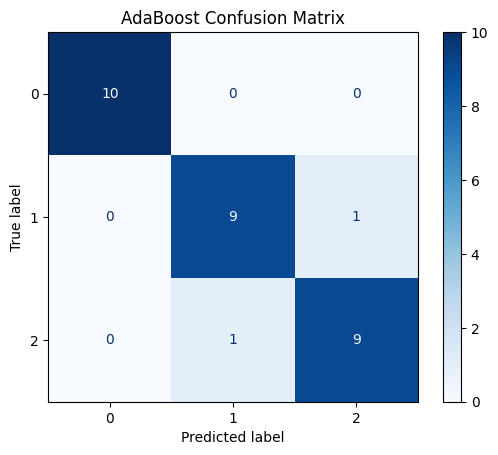


GradientBoosting Model Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



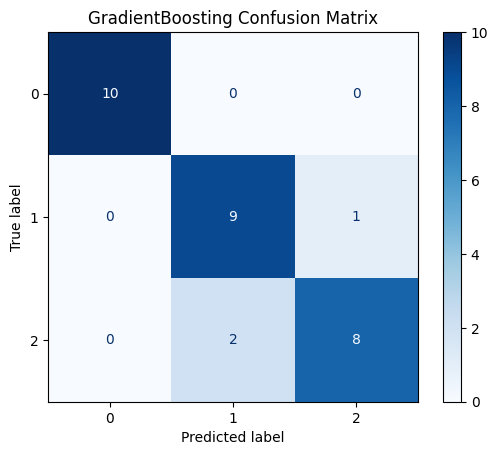


XGBoost Model Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



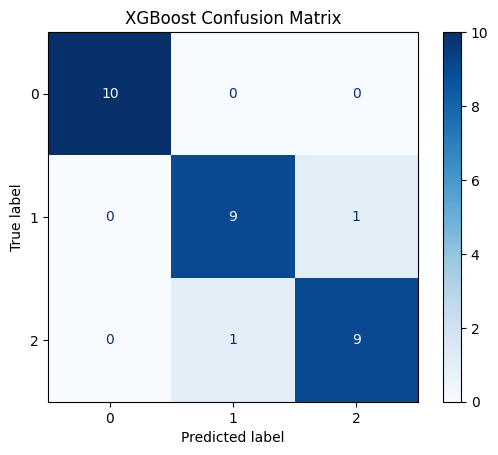

,Model,Accuracy,Precision,Recall,F1-Score
0,AdaBoost,0.933333,0.933333,0.933333,0.933333
1,GradientBoosting,0.900000,0.902357,0.900000,0.899749
2,XGBoost,0.933333,0.933333,0.933333,0.933333


In [8]:
models = {
    "AdaBoost": ada,
    "GradientBoosting": gbm,
    "XGBoost": xgb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })
    
    print(f"\n{name} Model Results:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Summary DataFrame
results_df = pd.DataFrame(results)
results_df


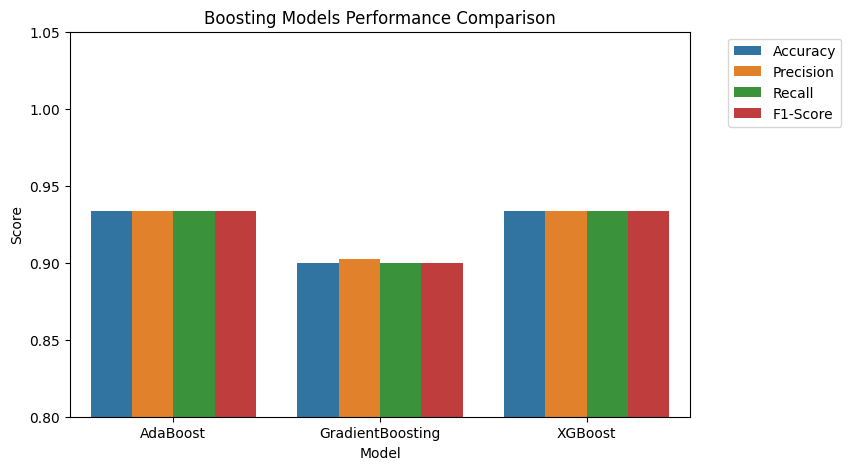

In [10]:
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Boosting Models Performance Comparison")
plt.ylim(0.8, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Voting Classifier Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



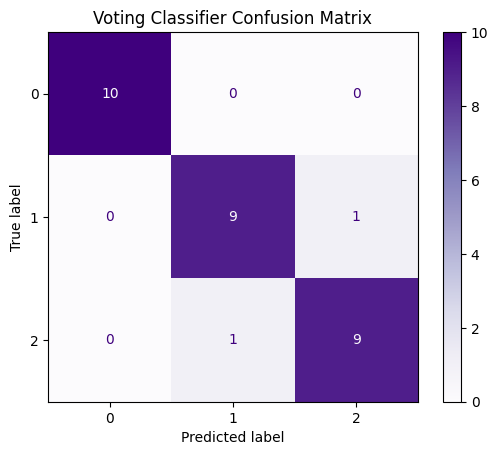

Voting Classifier - Accuracy: 0.933, Precision: 0.933, Recall: 0.933, F1: 0.933


In [12]:
# Voting Classifier (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[('AdaBoost', ada), ('GBM', gbm), ('XGBoost', xgb)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

acc_v = accuracy_score(y_test, y_pred_voting)
prec_v = precision_score(y_test, y_pred_voting, average='macro')
rec_v = recall_score(y_test, y_pred_voting, average='macro')
f1_v = f1_score(y_test, y_pred_voting, average='macro')

print("\nVoting Classifier Results:\n")
print(classification_report(y_test, y_pred_voting))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_voting)).plot(cmap="Purples")
plt.title("Voting Classifier Confusion Matrix")
plt.show()

print(f"Voting Classifier - Accuracy: {acc_v:.3f}, Precision: {prec_v:.3f}, Recall: {rec_v:.3f}, F1: {f1_v:.3f}")


In [14]:
results_df = results_df.append({
    "Model": "Voting Ensemble",
    "Accuracy": acc_v,
    "Precision": prec_v,
    "Recall": rec_v,
    "F1-Score": f1_v
}, ignore_index=True)

print("\n📊 Final Model Comparison:\n")
print(results_df)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Comparison of Boosting Models and Voting Ensemble")
plt.ylim(0.8, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'append'